In [2]:
import os
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("retentiondata_case.csv")
print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.head()

Shape: (5636, 36)
Columns: ['acct_ref', 'cust_ref', 'has_dependents', 'tenure_mo', 'home_phone', 'multi_line', 'internet_plan', 'add_on_security', 'add_on_backup', 'add_on_protection', 'tech_support_std', 'stream_tv', 'stream_movies', 'contract_term', 'e_bill_opt_in', 'pay_method', 'monthly_fee', 'total_billed', 'left_flag', 'fiscal_qtr', 'gender', 'age_years', 'is_married', 'dependents_count', 'referred_friend', 'referrals_count', 'recent_offer', 'avg_long_dist_fee', 'internet_tech', 'avg_gb_download', 'premium_support', 'stream_music', 'unlimited_data_opt', 'refunds_total', 'extra_data_fees_total', 'long_dist_fees_total']


,acct_ref,cust_ref,has_dependents,tenure_mo,home_phone,multi_line,internet_plan,add_on_security,add_on_backup,add_on_protection,...,recent_offer,avg_long_dist_fee,internet_tech,avg_gb_download,premium_support,stream_music,unlimited_data_opt,refunds_total,extra_data_fees_total,long_dist_fees_total
0,ACCT137932,CUST61880322,No,1,No,No phone service,DSL,No,Yes,No,...,Offer E,0.00,DSL,10,No,No,Yes,0.0,0,0.00
1,ACCT115088,CUST55192304,No,34,Yes,No,DSL,Yes,No,Yes,...,NaN,17.09,DSL,16,No,No,Yes,0.0,0,581.06
2,ACCT623423,CUST16890051,No,2,Yes,No,DSL,Yes,Yes,No,...,NaN,10.47,DSL,21,No,No,Yes,0.0,0,20.94
3,ACCT846960,CUST99388728,No,45,No,No phone service,DSL,Yes,No,Yes,...,NaN,0.00,DSL,10,Yes,No,Yes,0.0,0,0.00
4,ACCT146586,CUST91125265,No,2,Yes,No,Fiber optic,No,No,No,...,NaN,9.12,Fiber Optic,51,No,No,Yes,0.0,0,18.24


In [4]:
df['stream_count'] = (df[['stream_tv', 'stream_movies', 'stream_music']] == 'Yes').sum(axis=1)
df['add_on_count'] = (df[['add_on_security', 'add_on_backup', 'add_on_protection']] == 'Yes').sum(axis=1)

In [5]:
df = df.drop(columns = ['acct_ref', 'cust_ref','fiscal_qtr','recent_offer','gender'])
df['internet_tech'] = df['internet_tech'].fillna("No Internet")
df['total_billed'] = df['total_billed'].fillna(df['total_billed'].median())
#df = df.drop(columns = ['stream_tv', 'stream_movies', 'stream_music','add_on_security', 'add_on_backup', 'add_on_protection'])

In [6]:
df['tenure_group'] = pd.cut(
    df['tenure_mo'],
    bins=[0, 24, 48, float('inf')],
    labels=['Under 2 Years', '2-4 Years', 'Over 4 Years'],
    right=False
)

In [7]:
df['avg_monthly_spent'] = np.where(
    df['tenure_mo'] == 0,
    0,
    df['total_billed'] / df['tenure_mo']
)

Text(0, 0.5, '# of customers')

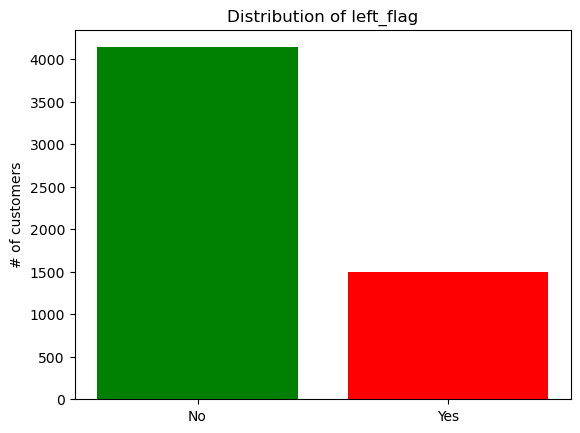

In [42]:
import matplotlib.pyplot as plt
counts = df['left_flag'].value_counts()

plt.bar(
    counts.index,
    counts.values,
    color=['red' if x == 'Yes' else 'green' for x in counts.index]
)
plt.title('Distribution of left_flag')
plt.ylabel('# of customers')


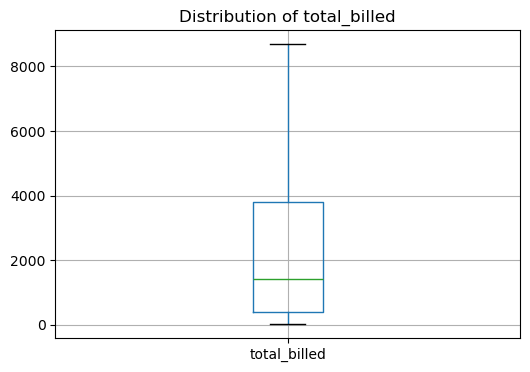

In [37]:
df.boxplot(column = 'total_billed', figsize=(6,4))
plt.title('Distribution of total_billed')
plt.show()

In [8]:
Y = (df["left_flag"] == "Yes").astype("int64") # returns True for rows where response == 1 and False otherwise then .astype(int) converts True→1 and False→0, so the “positive” label becomes 1
X = df.drop(columns=["left_flag"]) 

## XGBoost

In [9]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    test_size=0.3,     # 30% test, 70% train
    random_state=99,   # reproducibility
    shuffle=True       # shuffle before splitting
)

# Check shapes
X_train.shape, X_test.shape

((3945, 34), (1691, 34))

In [10]:
# Needed for preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder


# Identify column types from TRAIN ONLY
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=["number"]).columns.tolist()

# Build preprocessing (train-only learning happens during .fit())
# numeric variable imputation
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

#categorical variable imputation
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  
])

#Aplpy the preprocessing to numeric and categorical variables
preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

In [10]:
##!pip install xgboost


In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


# Stratified CV preserves class balance in each fold (important for classification)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)


# Pipeline with XGBoost model
xgb_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", XGBClassifier(
        objective="binary:logistic",
        n_jobs=2,          # use all cores
        eval_metric="auc",  # pairs well with scoring="roc_auc"
        tree_method="hist", # fast CPU histogram algorithm (use "gpu_hist" if you have a GPU)
        random_state=99
    ))
])

#  Hyperparameter grid (more parameters here: https://federated-xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)
param_grid = {
    "model__n_estimators": [50, 100, 150],
    "model__max_depth":    [2, 3, 4, 5],
    "model__learning_rate":[0.05, 0.1],
    "model__subsample":    [.5, 0.75, 1.0],
    "model__colsample_bytree": [0.7, 0.8],
    "model__min_child_weight": [1, 3, 5]
}

#  Cross-validated grid search (same scoring)
xgb_cv = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    refit=True
)

# Fit 
xgb_cv.fit(X_train, Y_train)


print("Best params selected by CV:", xgb_cv.best_params_)
print("Best CV ROC-AUC:", round(xgb_cv.best_score_, 3))


Best params selected by CV: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__min_child_weight': 1, 'model__n_estimators': 100, 'model__subsample': 1.0}
Best CV ROC-AUC: 0.903


cat__contract_term_Month-to-month    0.150403
cat__internet_plan_Fiber optic       0.090448
cat__tech_support_std_No             0.080791
cat__add_on_security_No              0.065813
cat__tenure_group_Under 2 Years      0.050451
cat__has_dependents_No               0.037772
cat__is_married_Yes                  0.036730
num__referrals_count                 0.036500
cat__contract_term_Two year          0.035971
cat__is_married_No                   0.027600
cat__has_dependents_Yes              0.026929
num__dependents_count                0.026909
cat__pay_method_Electronic check     0.023915
cat__contract_term_One year          0.022507
cat__add_on_security_Yes             0.020836
dtype: float32

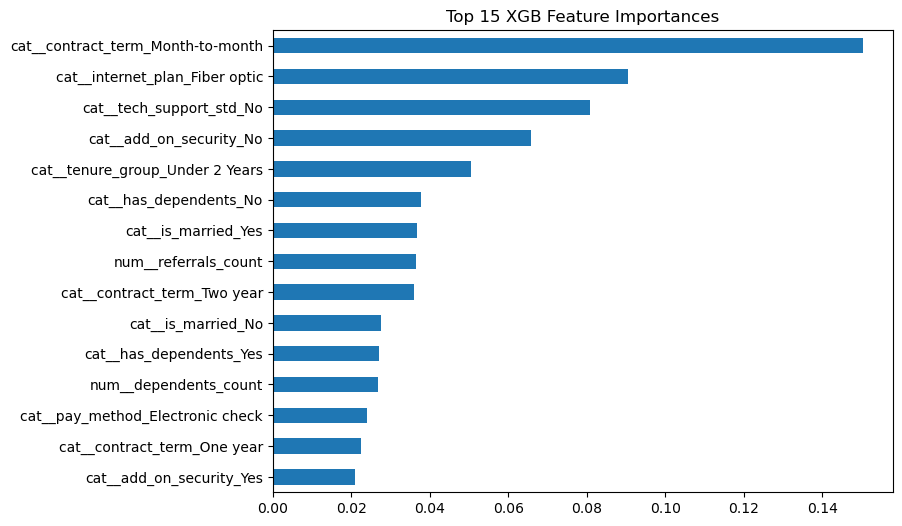

In [12]:
# Get best fitted model from GridSearchCV
best_xgb = xgb_cv.best_estimator_.named_steps["model"]

#get important features
pre = xgb_cv.best_estimator_.named_steps["preprocess"]
feature_names = pre.get_feature_names_out()
imp = pd.Series(best_xgb.feature_importances_, index=feature_names).sort_values(ascending=False)

display(imp.head(15))  # top 15 features


# Optional: plot top features
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
imp.head(15).plot(kind="barh", x="feature", y="importance", legend=False)
plt.title("Top 15 XGB Feature Importances")
plt.gca().invert_yaxis()
plt.show()

In [32]:
#!pip install shap

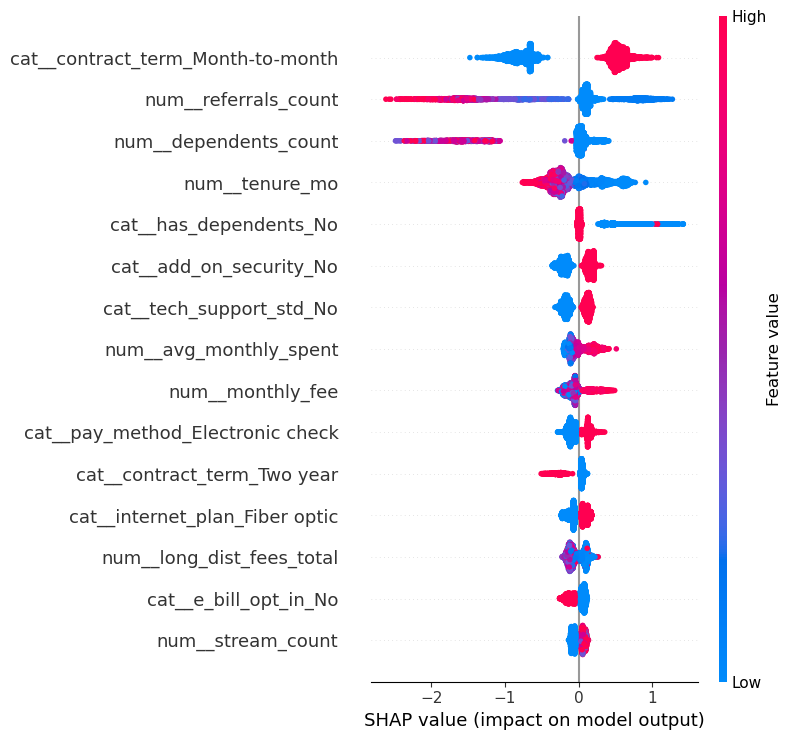

In [13]:
import shap                  

pre = xgb_cv.best_estimator_.named_steps["preprocess"]

#  Transform X the same way the model saw it
X_train_enc = pre.transform(X_train)

#  Get feature names after preprocessing (works for ColumnTransformer / Pipeline in sklearn >= 1.0)
feature_names = None
if hasattr(pre, "get_feature_names_out"):
    feature_names = pre.get_feature_names_out()
    
# Create SHAP explainer for tree-based models (e.g., XGBoost, LightGBM, RandomForest)
explainer   = shap.TreeExplainer(best_xgb)

# Compute SHAP values for the training set
# Each value shows how much a feature pushes a prediction toward class 1 (positive) or class 0 (negative)
shap_values = explainer.shap_values(X_train_enc)

# Overall PLot Beeswarm plot: this shows both which features matter most and the direction of their influence

shap.summary_plot(shap_values, X_train_enc, max_display=15, show=True,feature_names=feature_names)

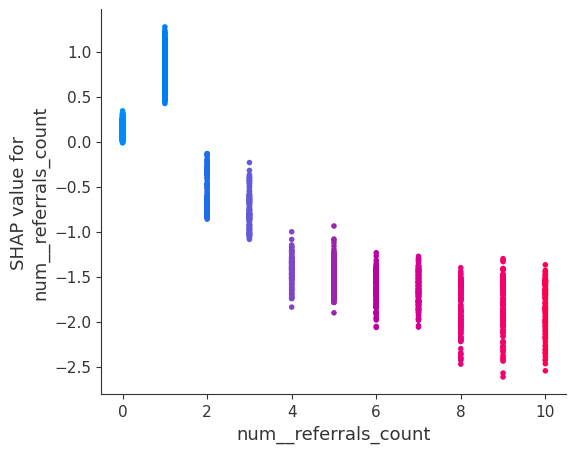

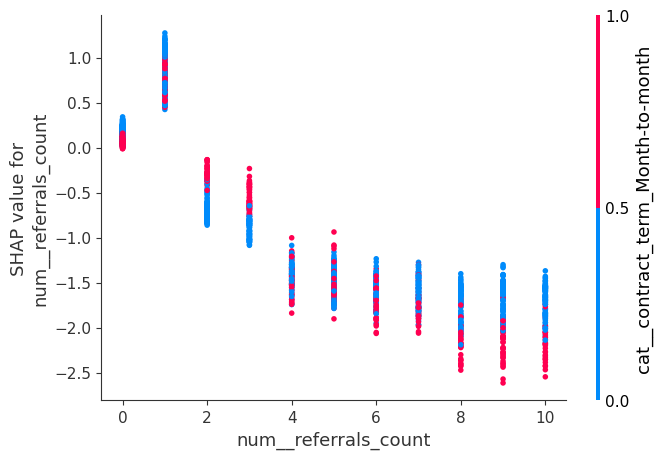

In [14]:
#Dependence plot for one feature
shap.dependence_plot("num__referrals_count", shap_values, X_train_enc, interaction_index="num__referrals_count", show=True,feature_names=feature_names)

# Dependence plot for one feature, colored by another feature
shap.dependence_plot("num__referrals_count", shap_values, X_train_enc, interaction_index="cat__contract_term_Month-to-month", show=True,feature_names=feature_names)

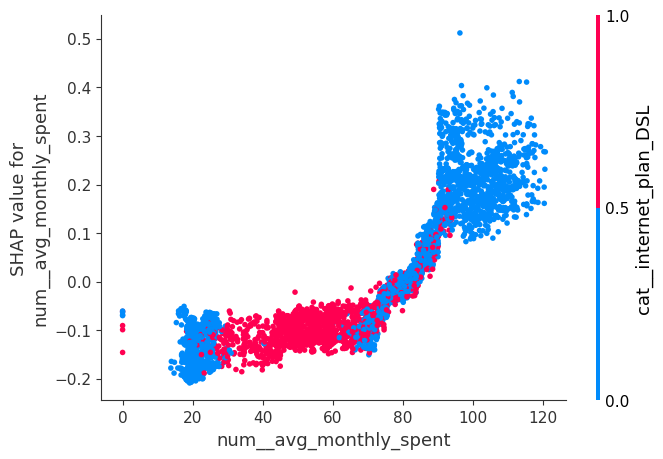

In [15]:
shap.dependence_plot(
    "num__avg_monthly_spent",
    shap_values,
    X_train_enc,
    interaction_index="cat__internet_plan_DSL",
    feature_names=feature_names
)

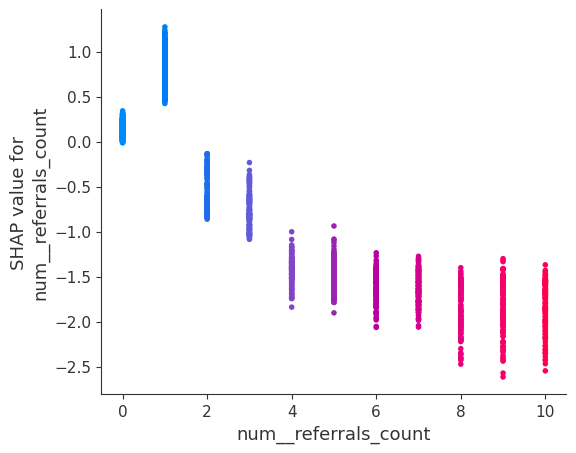

In [16]:
shap.dependence_plot(
    "num__referrals_count",
    shap_values,
    X_train_enc,
    interaction_index="num__referrals_count",
    feature_names=feature_names
)

In [17]:
feature_names

array(['num__tenure_mo', 'num__monthly_fee', 'num__total_billed',
       'num__age_years', 'num__dependents_count', 'num__referrals_count',
       'num__avg_long_dist_fee', 'num__avg_gb_download',
       'num__refunds_total', 'num__extra_data_fees_total',
       'num__long_dist_fees_total', 'num__stream_count',
       'num__add_on_count', 'num__avg_monthly_spent',
       'cat__has_dependents_No', 'cat__has_dependents_Yes',
       'cat__home_phone_No', 'cat__home_phone_Yes', 'cat__multi_line_No',
       'cat__multi_line_No phone service', 'cat__multi_line_Yes',
       'cat__internet_plan_DSL', 'cat__internet_plan_Fiber optic',
       'cat__internet_plan_No', 'cat__add_on_security_No',
       'cat__add_on_security_No internet service',
       'cat__add_on_security_Yes', 'cat__add_on_backup_No',
       'cat__add_on_backup_No internet service', 'cat__add_on_backup_Yes',
       'cat__add_on_protection_No',
       'cat__add_on_protection_No internet service',
       'cat__add_on_protection_Y

In [18]:
Ytest_prob = xgb_cv.predict_proba(X_test)[:, 1]

Test ROC-AUC: 0.9034


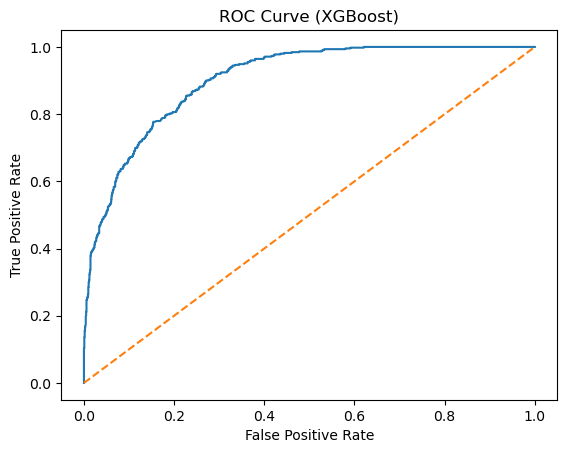

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt  

test_auc = roc_auc_score(Y_test, Ytest_prob)
print("Test ROC-AUC:", round(test_auc, 4))

# ROC curve (single plot; no custom colors)
fpr, tpr, _ = roc_curve(Y_test, Ytest_prob)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (XGBoost)")
plt.show()

## LASSO Logistic Regression

In [20]:
from sklearn.model_selection import train_test_split, StratifiedKFold

#Split into train/test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    test_size=0.3,     # 30% test, 70% train
    random_state=99,   # reproducibility
    shuffle=True       # shuffle before splitting
)

# Check shapes
X_train.shape, X_test.shape

((3945, 34), (1691, 34))

In [21]:
    # StandardScaler:     standardizes features (zero mean, unit variance)
    #                     important for LASSO because they are scale-sensitive
    from sklearn.preprocessing import StandardScaler
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.linear_model import LogisticRegressionCV
    
    
    # Stratified CV preserves class balance in each fold (important for classification)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
    # Lambda grid: 0001 to 2.0 in 20 steps
    lambdas = np.linspace(0.001, 2.0, 20)
    
    numeric_cols = X_train.select_dtypes(include=['int64','float64']).columns
    categorical_cols = X_train.select_dtypes(include=['object','category','bool']).columns
    
    preprocess = ColumnTransformer([
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ])
    
    
    logit_lasso_pipe = Pipeline([
        ("preprocess", preprocess),
        ("model", LogisticRegressionCV(
            Cs=1/lambdas,
            cv=cv,
            penalty="l1",
            solver="saga",
            scoring="roc_auc",
            max_iter=2000,
            n_jobs=-1,
            refit=True
        ))
    ])
    
    
    logit_lasso_pipe.fit(X_train, Y_train)
    
    best_C = logit_lasso_pipe.named_steps["model"].C_[0] # best 1/lambda value the minimizes AUC on holdout sets in cross-validation
    best_lambda = 1.0 / best_C
    
    print(f"Best C selected by CV: {best_C:.6g}   (λ = 1/C ≈ {best_lambda:.6g})")

C:\Users\miles\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best C selected by CV: 0.593694   (λ = 1/C ≈ 1.68437)


In [22]:
# Get coefficients from the fitted LASSO model it automatically chooses the best C(1/λ)
lasso_model = logit_lasso_pipe.named_steps["model"]

preprocess = logit_lasso_pipe.named_steps["preprocess"]
feature_names = preprocess.get_feature_names_out()


# Match each coefficient with its feature name
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": lasso_model.coef_.ravel()   # .coef_ is shape (1, n_features) for binary;
                                               # ravel() flattens it into a 1-D array
})

# Keep only non-zero coefficients (the ones LASSO thinks are important)
important_coefs = coef_df[coef_df["coefficient"] != 0]

# Sort by absolute size of the coefficient -- the larger the more important
important_coefs = important_coefs.reindex(
    important_coefs["coefficient"].abs().sort_values(ascending=False).index
)

print("Important features selected by LASSO:")
display(important_coefs)

Important features selected by LASSO:


,feature,coefficient
22,cat__internet_plan_Fiber optic,2.049624
57,cat__internet_tech_Fiber Optic,-1.861873
5,num__referrals_count,-1.831604
0,num__tenure_mo,-1.309275
53,cat__referred_friend_No,-1.195342
4,num__dependents_count,-1.022342
14,cat__has_dependents_No,-0.964394
42,cat__contract_term_Month-to-month,0.845724
66,cat__tenure_group_Over 4 Years,0.569285
51,cat__is_married_No,-0.441505


In [23]:
Y_pred_lasso = logit_lasso_pipe.predict(X_test)

In [24]:
# Manual calculation of MSE for LASSO
errors = Y_test - Y_pred_lasso        # residuals = actual - predicted
squared_errors = errors ** 2          # square each residual
mse = squared_errors.mean()    # average of squared residuals

print("Test MSE — LASSO (manual):", mse)

Test MSE — LASSO (manual): 0.17740981667652278


In [25]:
from sklearn.metrics import roc_auc_score
 
y_prob = logit_lasso_pipe.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(Y_test, y_prob)
 
print(f"Test ROC-AUC: {roc_auc:.3f}")

Test ROC-AUC: 0.888


## Random Forest

In [26]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    test_size=0.3,     # 30% test, 70% train
    random_state=99,   # reproducibility
    shuffle=True       # shuffle before splitting
)

# Check shapes
X_train.shape, X_test.shape

((3945, 34), (1691, 34))

In [27]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# First, identify which columns are numeric and which are categorical
# This is an example - you'll need to adjust based on your actual data
import pandas as pd
import numpy as np

# Assuming X_train is a pandas DataFrame
# Identify categorical columns (object or string dtype)
categorical_cols = X_train.select_dtypes(include=['object', 'string', 'category']).columns.tolist()
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create preprocessing steps for different column types
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Stratified CV preserves class balance in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# Define pipeline with preprocessing and Random Forest
rf_pipe = Pipeline([
    ("preprocessor", preprocessor),  # Add preprocessing step
    ("model", RandomForestClassifier(
        n_jobs=-1,
        class_weight="balanced",
        random_state=99
    ))
])

# Grid of hyperparameters to tune
param_grid = {
    "model__max_features": ["sqrt", "log2", None, 0.3, 0.5]
}

# Run cross-validated grid search
rf_cv = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",   
    n_jobs=-1,
    refit=True
)

rf_cv.fit(X_train, Y_train)

print("Best params selected by CV:", rf_cv.best_params_)
print("Best CV ROC-AUC:", round(rf_cv.best_score_, 3))

Best params selected by CV: {'model__max_features': 0.3}
Best CV ROC-AUC: 0.883


In [28]:
rf_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        n_jobs=-1,
        class_weight="balanced",
        random_state=99
    ))
])

# Reduced parameter grid for faster execution
param_grid = {
    "model__n_estimators": [400],          # Reduced from [400, 500, 600]
    "model__max_depth": [3, 5],            # Reduced from [3, 4, 5]
    "model__min_samples_split": [2, 10],   # Reduced from [2, 5, 10]
    "model__min_samples_leaf": [1, 4],     # Reduced from [1, 2, 4]
    "model__max_features": ["sqrt"]        # Reduced from ["sqrt", "log2"]
}

# Run cross-validated grid search with limited resources
rf_cv = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid,
    cv=cv,                      
    scoring="roc_auc",
    n_jobs=2,                   # Reduced from -1 to limit CPU usage
    refit=True,
    verbose=1                   # Added to monitor progress
)

# Only fit if data is available
if 'X_train' in locals() and 'Y_train' in locals():
    # Train the model with grid search
    rf_cv.fit(X_train, Y_train)
    
    # Print results
    print("Best params selected by CV:", rf_cv.best_params_)
    print("Best CV ROC-AUC:", round(rf_cv.best_score_, 3))
else:
    print("Cannot fit model: X_train and/or Y_train not defined")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params selected by CV: {'model__max_depth': 5, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 400}
Best CV ROC-AUC: 0.871


In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# First, identify which columns are numeric and which are categorical
# This is an example - you'll need to adjust based on your actual data
import pandas as pd
import numpy as np

# Assuming X_train is a pandas DataFrame
# Identify categorical columns (object or string dtype)
categorical_cols = X_train.select_dtypes(include=['object', 'string', 'category']).columns.tolist()
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create preprocessing steps for different column types
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Stratified CV preserves class balance in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# Define pipeline with preprocessing and Random Forest
rf_pipe = Pipeline([
    ("preprocessor", preprocessor),  # Add preprocessing step
    ("model", RandomForestClassifier(
        n_jobs=-1,
        class_weight="balanced",
        random_state=99
    ))
])

# Grid of hyperparameters to tune
param_grid = {
    "model__max_features": ["sqrt", "log2", None, 0.3, 0.5]
}

# Run cross-validated grid search
rf_cv = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",   
    n_jobs=-1,
    refit=True
)

rf_cv.fit(X_train, Y_train)

print("Best params selected by CV:", rf_cv.best_params_)
print("Best CV ROC-AUC:", round(rf_cv.best_score_, 3))

Best params selected by CV: {'model__max_features': 0.3}
Best CV ROC-AUC: 0.883


Length of importances: 68
Length of X_train columns: 34
    feature_index  importance
42             42    0.108461
5               5    0.103489
13             13    0.060174
2               2    0.059703
0               0    0.057691
1               1    0.054126
10             10    0.052853
6               6    0.047883
3               3    0.046474
24             24    0.043012
7               7    0.039769
4               4    0.030242
33             33    0.023622
44             44    0.017684
22             22    0.017072


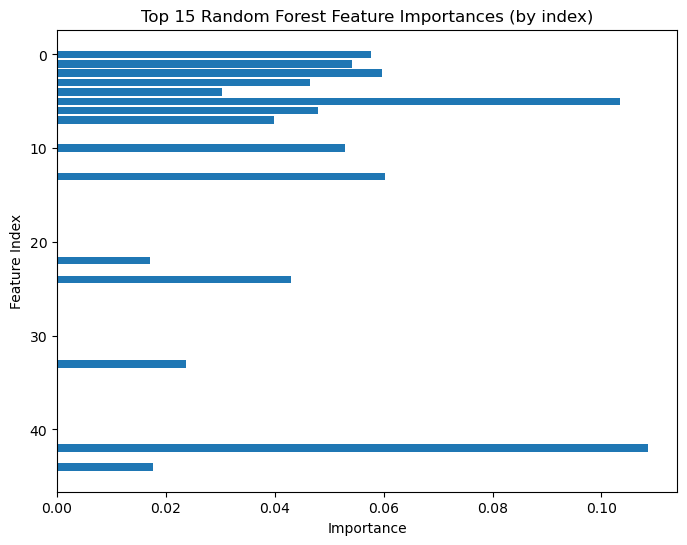

In [30]:
# Get best fitted model from GridSearchCV
best_rf = rf_cv.best_estimator_.named_steps["model"]

# Get feature importances
importances = best_rf.feature_importances_

# Debug information to understand the mismatch
print(f"Length of importances: {len(importances)}")
print(f"Length of X_train columns: {len(X_train.columns)}")

# Alternative approach: Create indices for features
feature_indices = range(len(importances))

# Create DataFrame with indices instead of potentially mismatched feature names
feat_imp = pd.DataFrame({
    "feature_index": feature_indices,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(feat_imp.head(15))  # top 15 features

# Optional: plot top features using indices
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
top_15 = feat_imp.head(15)
plt.barh(top_15['feature_index'], top_15['importance'])
plt.title("Top 15 Random Forest Feature Importances (by index)")
plt.ylabel("Feature Index")
plt.xlabel("Importance")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


Could not map to categories automatically: [Errno 2] No such file or directory: 'your_data.csv'
Using feature indices instead
       feature  importance
42  Feature_42    0.108461
5    Feature_5    0.103489
13  Feature_13    0.060174
2    Feature_2    0.059703
0    Feature_0    0.057691
1    Feature_1    0.054126
10  Feature_10    0.052853
6    Feature_6    0.047883
3    Feature_3    0.046474
24  Feature_24    0.043012
7    Feature_7    0.039769
4    Feature_4    0.030242
33  Feature_33    0.023622
44  Feature_44    0.017684
22  Feature_22    0.017072


<Figure size 800x600 with 0 Axes>

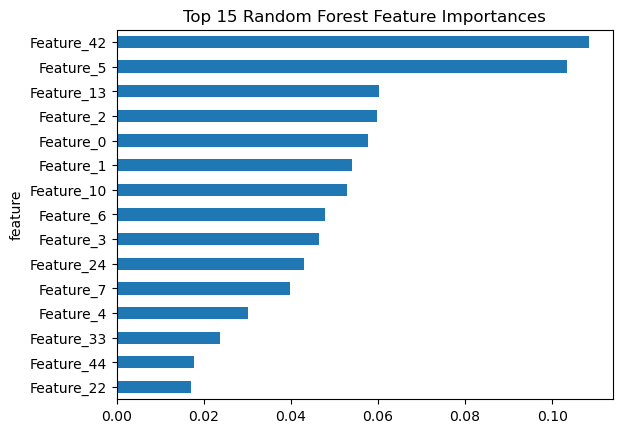

In [31]:
# Get best fitted model from GridSearchCV
best_rf = rf_cv.best_estimator_.named_steps["model"]

# Get feature importances
importances = best_rf.feature_importances_

# Create feature names based on indices if actual names can't be matched
# This ensures arrays will be the same length
feature_indices = [f"Feature_{i}" for i in range(len(importances))]

# Create DataFrame with guaranteed matching lengths
feat_imp = pd.DataFrame({
    "feature": feature_indices,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Map indices to categories if you have a category mapping
# Replace this dictionary with your actual mapping of feature indices to categories
# For example: {0: "Age", 1: "Income", 2: "Education", ...}
category_mapping = {}

# Try to load categories from your CSV (adjust as needed)
try:
    import pandas as pd
    # Load your CSV file - replace with your actual file path
    df = pd.read_csv('your_data.csv')
    
    # Create mapping from index to column name
    # Only map as many as we have importances
    for i, col in enumerate(df.columns[:len(importances)]):
        category_mapping[i] = col
        
    # Apply the mapping to convert indices to actual categories
    feat_imp['feature'] = feat_imp['feature'].apply(
        lambda x: category_mapping.get(int(x.split('_')[1]), x)
    )
    
    print("Successfully mapped feature indices to categories")
except Exception as e:
    print(f"Could not map to categories automatically: {e}")
    print("Using feature indices instead")

print(feat_imp.head(15))  # top 15 features

# Plot top features
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
feat_imp.head(15).plot(kind="barh", x="feature", y="importance", legend=False)
plt.title("Top 15 Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.show()

Could not get feature names directly from model
Creating feature mapping manually...
CSV columns:
0: acct_ref
1: cust_ref
2: has_dependents
3: tenure_mo
4: home_phone
5: multi_line
6: internet_plan
7: add_on_security
8: add_on_backup
9: add_on_protection
10: tech_support_std
11: stream_tv
12: stream_movies
13: contract_term
14: e_bill_opt_in
15: pay_method
16: monthly_fee
17: total_billed
18: left_flag
19: fiscal_qtr
20: gender
21: age_years
22: is_married
23: dependents_count
24: referred_friend
25: referrals_count
26: recent_offer
27: avg_long_dist_fee
28: internet_tech
29: avg_gb_download
30: premium_support
31: stream_music
32: unlimited_data_opt
33: refunds_total
34: extra_data_fees_total
35: long_dist_fees_total

Top 15 features by importance:
               feature  importance
42  Unknown_Feature_42    0.108461
5           multi_line    0.103489
13       contract_term    0.060174
2       has_dependents    0.059703
0             acct_ref    0.057691
1             cust_ref    0.05

<Figure size 1000x800 with 0 Axes>

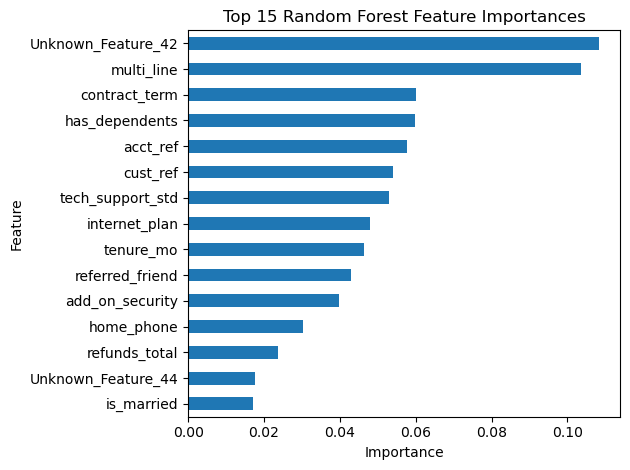

In [32]:
# Get best fitted model from GridSearchCV
best_rf = rf_cv.best_estimator_.named_steps["model"]

# Get feature importances
importances = best_rf.feature_importances_

# Step 1: Identify which features were actually used in the model
# If you have access to the pipeline that created the model:
try:
    # Try to get feature names directly from the model if available
    feature_names = best_rf.feature_names_in_
    print("Successfully retrieved feature names from model")
except:
    print("Could not get feature names directly from model")
    feature_names = None

# If feature names aren't available from the model, we need to recreate the mapping
if feature_names is None:
    print("Creating feature mapping manually...")
    
    # Option 1: If you know which columns from your CSV were used as features
    # Replace 'your_data.csv' with your actual CSV file path
    import pandas as pd
    original_data = pd.read_csv('retentiondata_case.csv')
    
    # Print column names to help identify which were used
    print("CSV columns:")
    for i, col in enumerate(original_data.columns):
        print(f"{i}: {col}")
    
    # Create a mapping based on the preprocessing you applied
    # For example, if you used all columns except 'target':
    feature_names = [col for col in original_data.columns if col != 'target_column_name']
    
    # If you applied one-hot encoding, you might need to expand categorical columns
    # This is a simplified example - adjust based on your actual preprocessing
    categorical_cols = []  # List of categorical columns that were one-hot encoded
    for col in categorical_cols:
        # Get unique values in the column
        unique_values = original_data[col].unique()
        # Remove the original column name
        feature_names.remove(col)
        # Add one-hot encoded column names
        for val in unique_values:
            feature_names.append(f"{col}_{val}")

# Ensure we have the right number of feature names
if len(feature_names) != len(importances):
    print(f"Warning: Feature count mismatch. Features: {len(feature_names)}, Importances: {len(importances)}")
    # Truncate or pad the feature names list as needed
    if len(feature_names) > len(importances):
        feature_names = feature_names[:len(importances)]
    else:
        # If we have fewer feature names than importances, add placeholder names
        feature_names = list(feature_names) + [f"Unknown_Feature_{i}" for i in range(len(feature_names), len(importances))]

# Create DataFrame with feature names and importances
feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print("\nTop 15 features by importance:")
print(feat_imp.head(15))

# Plot top features
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
feat_imp.head(15).plot(kind="barh", x="feature", y="importance", legend=False)
plt.title("Top 15 Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

Investigating pipeline steps...
Pipeline step: preprocessor, Type: ColumnTransformer
Pipeline step: model, Type: RandomForestClassifier

Preprocessor details:
ColumnTransformer(transformers=[('num', SimpleImputer(strategy='median'),
                                 ['tenure_mo', 'monthly_fee', 'total_billed',
                                  'age_years', 'dependents_count',
                                  'referrals_count', 'avg_long_dist_fee',
                                  'avg_gb_download', 'refunds_total',
                                  'extra_data_fees_total',
                                  'long_dist_fees_total', 'stream_count',
                                  'add_on_count', 'avg_monthly_spent']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['has_dependents', 'home_phone', 'multi_line',
                                  'internet_plan', 'add_on_security',
                                  'add_on_

<Figure size 1000x800 with 0 Axes>

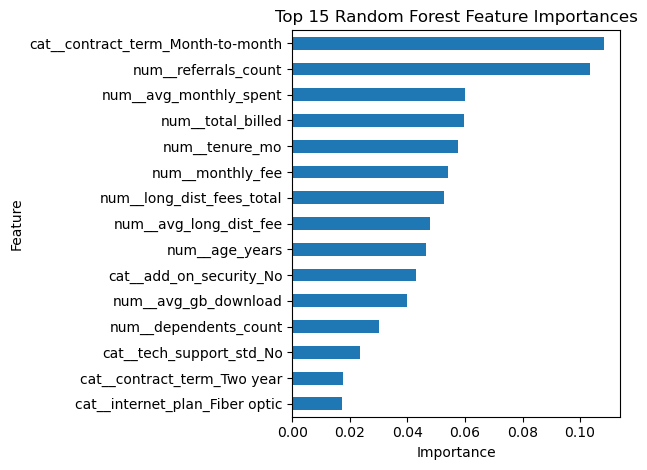


Saved complete feature importances to 'feature_importances.csv'


In [33]:
# Get best fitted model from GridSearchCV
best_rf = rf_cv.best_estimator_.named_steps["model"]

# Get feature importances
importances = best_rf.feature_importances_

# STEP 1: Investigate the full pipeline to understand feature transformations
print("Investigating pipeline steps...")
try:
    # Print all steps in the pipeline
    for step_name, step in rf_cv.best_estimator_.named_steps.items():
        print(f"Pipeline step: {step_name}, Type: {type(step).__name__}")
    
    # Try to access the preprocessor if it exists
    if 'preprocessor' in rf_cv.best_estimator_.named_steps:
        preprocessor = rf_cv.best_estimator_.named_steps['preprocessor']
        print("\nPreprocessor details:")
        print(preprocessor)
        
        # If using ColumnTransformer, we can get more details
        if hasattr(preprocessor, 'transformers_'):
            print("\nColumn transformer details:")
            for name, transformer, columns in preprocessor.transformers_:
                print(f"Transformer: {name}")
                print(f"  Applied to columns: {columns}")
                print(f"  Type: {type(transformer).__name__}")
except Exception as e:
    print(f"Error investigating pipeline: {e}")

# STEP 2: Try to get feature names from the pipeline
try:
    # Method 1: Try to get feature names directly from the model
    if hasattr(best_rf, 'feature_names_in_'):
        feature_names = best_rf.feature_names_in_
        print(f"\nFeature names from model: {len(feature_names)} features found")
    
    # Method 2: If using sklearn >= 1.0, try get_feature_names_out from preprocessor
    elif 'preprocessor' in rf_cv.best_estimator_.named_steps:
        preprocessor = rf_cv.best_estimator_.named_steps['preprocessor']
        if hasattr(preprocessor, 'get_feature_names_out'):
            feature_names = preprocessor.get_feature_names_out()
            print(f"\nFeature names from preprocessor: {len(feature_names)} features found")
    
    # If we found feature names and they match the importances length
    if 'feature_names' in locals() and len(feature_names) == len(importances):
        print("Successfully matched feature names with importances!")
    else:
        print("Could not automatically match feature names")
        feature_names = None
except Exception as e:
    print(f"Error getting feature names: {e}")
    feature_names = None

# STEP 3: If automatic methods failed, reconstruct feature names
if feature_names is None or len(feature_names) != len(importances):
    print("\nReconstructing feature names manually...")
    
    # Load your original data
    import pandas as pd
    # Replace with your actual CSV file path
    original_data = pd.read_csv('your_data.csv')
    
    # Print column information to help with debugging
    print("\nOriginal CSV columns:")
    for i, col in enumerate(original_data.columns):
        print(f"{i}: {col}")
    
    # Ask user to provide column information
    print(f"\nYour model uses {len(importances)} features.")
    print("Please check your preprocessing steps to identify all features used.")
    print("Common transformations that expand features include:")
    print("1. One-hot encoding of categorical variables")
    print("2. Polynomial features")
    print("3. Interaction terms")
    print("4. Text vectorization")
    
    # Create placeholder feature names that are more informative
    feature_names = [f"Feature_{i}" for i in range(len(importances))]

# STEP 4: Create and display feature importance DataFrame
feat_imp = pd.DataFrame({
    "feature": feature_names if feature_names is not None else [f"Feature_{i}" for i in range(len(importances))],
    "importance": importances
}).sort_values(by="importance", ascending=False)

print("\nTop 15 features by importance:")
print(feat_imp.head(15))

# STEP 5: Plot feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
top_n = 15  # Show top 15 features
feat_imp.head(top_n).plot(kind="barh", x="feature", y="importance", legend=False)
plt.title(f"Top {top_n} Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

# STEP 6: Save feature importances to CSV for further analysis
feat_imp.to_csv("feature_importances.csv", index=False)
print("\nSaved complete feature importances to 'feature_importances.csv'")

In [35]:
Ytest_prob = rf_cv.predict_proba(X_test)[:, 1]

Test ROC-AUC: 0.8736


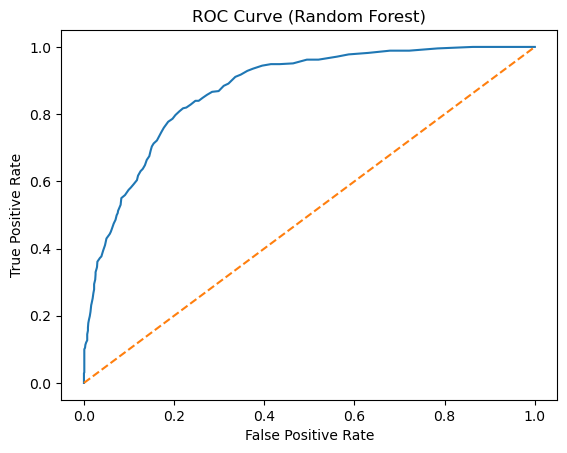

In [36]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt  

test_auc = roc_auc_score(Y_test, Ytest_prob)
print("Test ROC-AUC:", round(test_auc, 4))

# ROC curve (single plot; no custom colors)
fpr, tpr, _ = roc_curve(Y_test, Ytest_prob)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Random Forest)")
plt.show()